<h1>2. Machine Learning Models </h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import os
import gc

import re
from nltk.corpus import stopwords as nltk_stop
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE

from os import path
from PIL import Image

from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import log_loss
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from collections import Counter, defaultdict
from scipy.sparse import hstack

from sqlalchemy import create_engine # database connection

import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold

from sklearn.exceptions import ConvergenceWarning

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

<h2> 2.1 Reading data from file and getting ready for applying ML Models </h2>

In [2]:
### Read the data and the features from the CSV file
Features = "Advance"

df_basic = pd.read_csv("BasicFeatures.csv",encoding='latin-1')
df_adv = pd.read_csv("AdvancedFeatures.csv",encoding='latin-1')
#df_embedd = pd.read_csv("glove_6B_50d_features.csv",encoding='latin-1')


In [3]:
df_basic.head()

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [4]:
df_adv.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [5]:
## Import the word embedding need to use. 

In [6]:
## Prepare the data
if Features == "Basic" :   
    data= df_basic
    y_true = data['is_duplicate']
    y_true = list(map(int, y_true))
    data.drop(['id','is_duplicate'], axis=1, inplace=True)
elif Features == "Advance": 
    data= df_basic
    y_true = data['is_duplicate']
    data.drop(['is_duplicate'], axis=1, inplace=True)
    data  = data.merge(df_adv, on='id',how='left')
    data.drop(['id','is_duplicate'], axis=1, inplace=True)
    y_true = list(map(int, y_true))
elif Features == "Embedd": 
    data= df_basic
    y_true = data['is_duplicate']
    data.drop(['is_duplicate'], axis=1, inplace=True)
    data  = data.merge(df_adv, on='id',how='left')
    data.drop(['is_duplicate'], axis=1, inplace=True)
    data  = data.merge(df_embedd, on='id',how='left')
    data.drop(['id','is_duplicate'], axis=1, inplace=True)
    y_true = list(map(int, y_true))
data.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,1,1,66,57,14,12,10.0,23.0,0.434783,2,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,4,1,51,88,8,13,4.0,20.0,0.200000,5,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h2>2.2 Converting strings to numerics</h2>

In [7]:
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio


<h2> 2.3 Random train test split( 70:30) </h2>

In [8]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 26)
Number of data points in test data : (121287, 26)


In [9]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in test data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


<h3> 2.4 Plot the confusion_matrix and call this function when we need </h2>

In [10]:
# This function plots the confusion matrices given y_i, y_i_hat.

def plot_confusion_matrix(test_y, predict_y, plot="Yes"):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    print(C)
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    Accuracy = (C[0,0] + C[1,1])/(C[0,0] + C[1,1] + C[0,1] + C[1,0] )
    print("Overall Accuracy" , Accuracy)
    # representing A in heatmap format
    if (plot == "yes") :
        cmap=sns.light_palette("red")
        plt.subplot(1, 3, 1)
        sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Class')
        plt.ylabel('Original Class')
        plt.title("Confusion matrix")
        
        plt.subplot(1, 3, 2)
        sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Class')
        plt.ylabel('Original Class')
        plt.title("Precision matrix")
        
        plt.subplot(1, 3, 3)
        # representing B in heatmap format
        sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Class')
        plt.ylabel('Original Class')
        plt.title("Recall matrix")
        
        plt.show()

<h2> 2.5 Logistic Regression with hyperparameter tuning </h2>

1e-05
For values of alpha =  1e-05 The log loss is: 0.42564892965345585
0.0001


C:\Users\ankesh.anupam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\ankesh.anupam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\ankesh.anupam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\ankesh.anupam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration re

For values of alpha =  0.0001 The log loss is: 0.45995450526537024
0.001
For values of alpha =  0.001 The log loss is: 0.46509318369000086
0.01
For values of alpha =  0.01 The log loss is: 0.44208253487175747
0.1
For values of alpha =  0.1 The log loss is: 0.45084892578013114
1
For values of alpha =  1 The log loss is: 0.49063288997430354
10
For values of alpha =  10 The log loss is: 0.5459532952954267


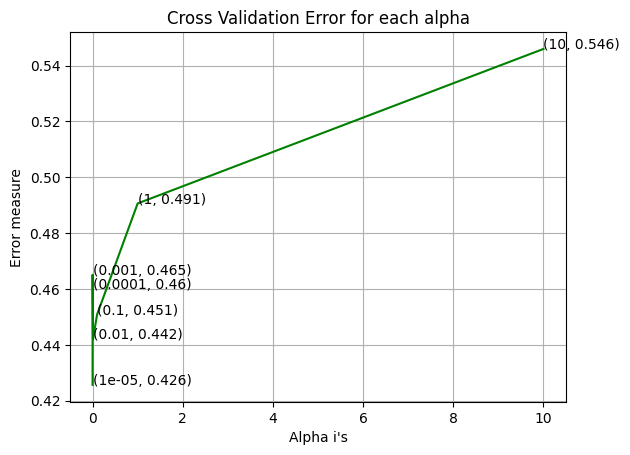

C:\Users\ankesh.anupam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\ankesh.anupam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\ankesh.anupam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\ankesh.anupam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log'

For values of best alpha =  1e-05 The train log loss is: 0.4218203127329179
For values of best alpha =  1e-05 The test log loss is: 0.42564892965345585
Total number of data points : 121287


In [11]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
 
#------------------------------

from sklearn.metrics import log_loss
log_error_array=[]
for i in alpha:
    print(i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y_train = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15))
predict_y_test = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y_test,axis=1)
print("Total number of data points :", len(predicted_y))


[[68392  8116]
 [17419 27360]]
Overall Accuracy 0.7894663071887341


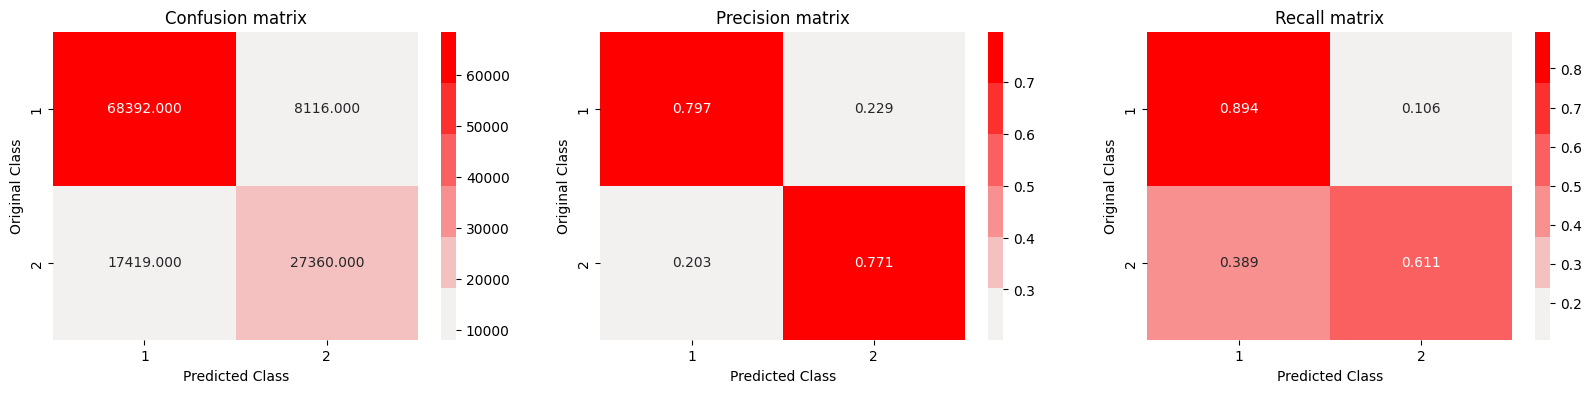

In [12]:
plot_confusion_matrix(y_test, predicted_y , "yes")

<h2> 2.7 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4430993302147816
For values of alpha =  0.0001 The log loss is: 0.44960051010548735
For values of alpha =  0.001 The log loss is: 0.45445989325574637
For values of alpha =  0.01 The log loss is: 0.4661528694024902
For values of alpha =  0.1 The log loss is: 0.4718886479522352
For values of alpha =  1 The log loss is: 0.574585612728791
For values of alpha =  10 The log loss is: 0.618263540701936


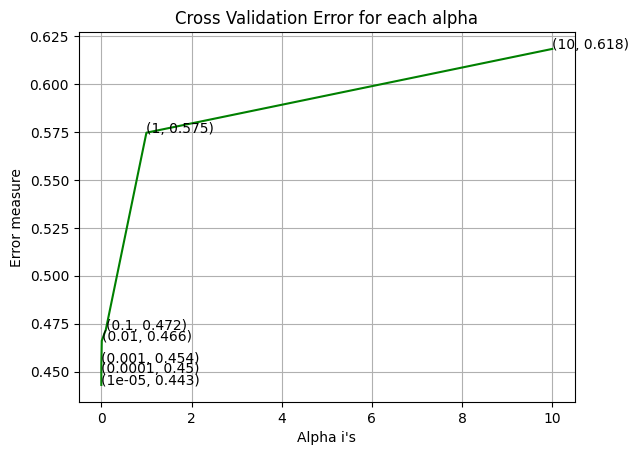

For values of best alpha =  1e-05 The train log loss is: 0.4395596791163914
For values of best alpha =  1e-05 The test log loss is: 0.4430993302147816
Total number of data points : 121287
[[67071  9437]
 [17352 27427]]
Overall Accuracy 0.7791271941757979


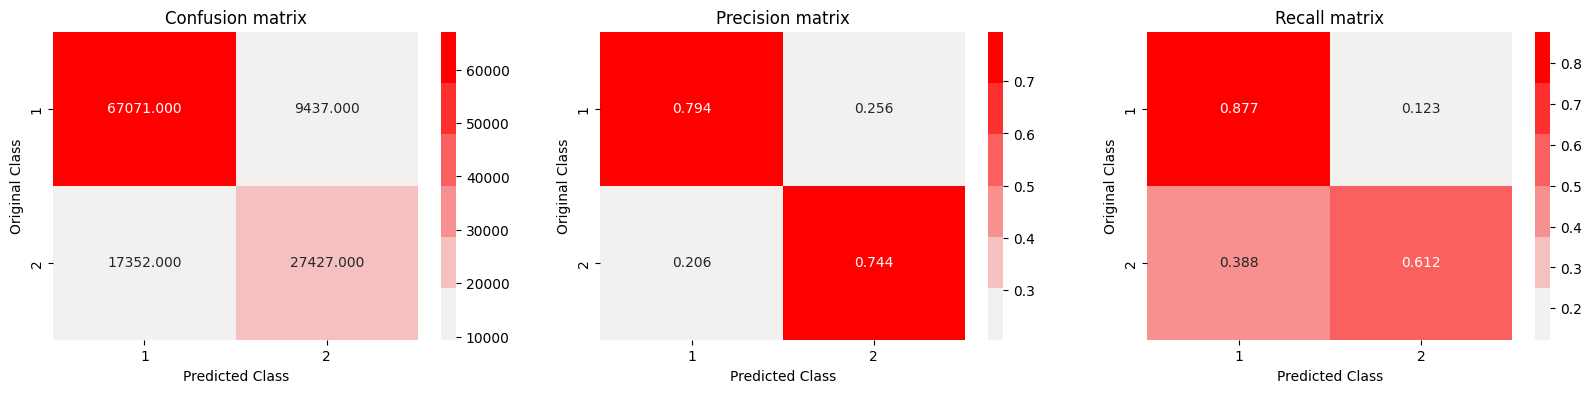

In [13]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
    

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge',max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y_train = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15))
predict_y_test = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y_test,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y , "yes")

<h2> 2.8 Applying XGBoost </h2>

C:\Users\ankesh.anupam\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-logloss:0.68483	valid-logloss:0.68491
[10]	train-logloss:0.61499	valid-logloss:0.61563
[20]	train-logloss:0.56415	valid-logloss:0.56522
[30]	train-logloss:0.52589	valid-logloss:0.52735
[40]	train-logloss:0.49637	valid-logloss:0.49816
[50]	train-logloss:0.47346	valid-logloss:0.47549
[60]	train-logloss:0.45519	valid-logloss:0.45741
[70]	train-logloss:0.44056	valid-logloss:0.44293
[80]	train-logloss:0.42859	valid-logloss:0.43110
[90]	train-logloss:0.41901	valid-logloss:0.42163
[100]	train-logloss:0.41109	valid-logloss:0.41379
[110]	train-logloss:0.40444	valid-logloss:0.40722
[120]	train-logloss:0.39896	valid-logloss:0.40181
[130]	train-logloss:0.39414	valid-logloss:0.39705
[140]	train-logloss:0.38996	valid-logloss:0.39291
[150]	train-logloss:0.38654	valid-logloss:0.38948
[160]	train-logloss:0.38357	valid-logloss:0.38652
[170]	train-logloss:0.38096	valid-logloss:0.38393
[180]	train-logloss:0.37874	valid-logloss:0.38172
[190]	train-logloss:0.37661	valid-logloss:0.37960
[200]	train

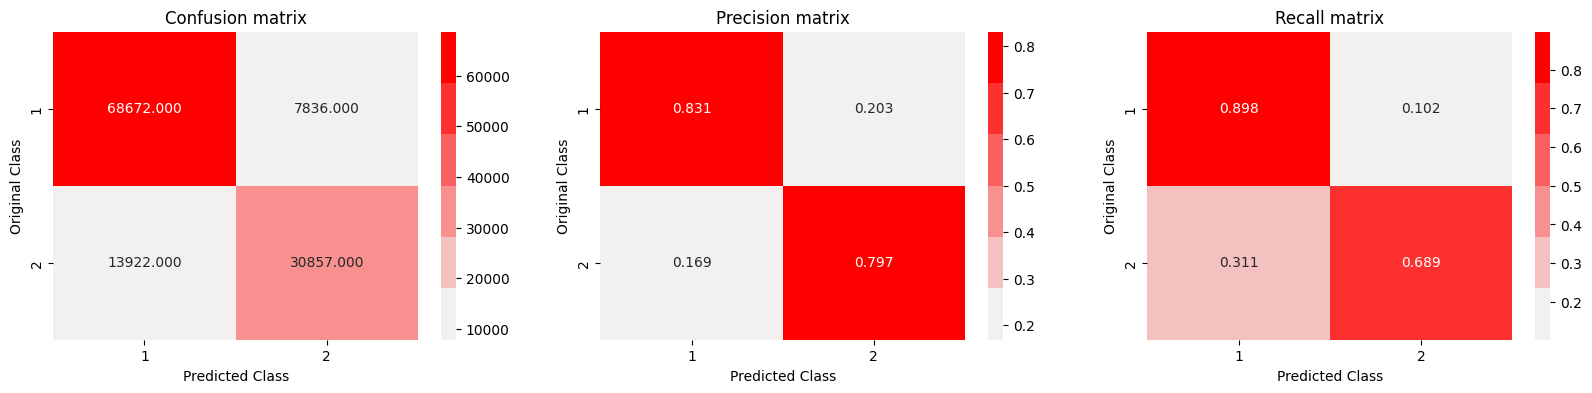

In [14]:
# For ignoring ConvergenceWarning

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
    

import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y , "yes")

In [15]:

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
rf_clf = RandomForestClassifier(n_estimators=100 , criterion = "gini")
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [17]:
print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 99.97%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  weighted avg
precision       0.999826       0.999512   0.99971       0.999669       0.99971
recall          0.999714       0.999703   0.99971       0.999709       0.99971
f1-score        0.999770       0.999608   0.99971       0.999689       0.99971
support    178519.000000  104484.000000   0.99971  283003.000000  283003.00000
_______________________________________________
Confusion Matrix: 
 [[178468     51]
 [    31 104453]]

Test Result:
Accuracy Score: 83.30%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.851985      0.796269  0.832975       0.824127       0.831415
recall         0.889802      0.735881  0.832975       0.812842       0.832975
f1-score       0.870483      0.764885  0.832975     

In [18]:
## Implemeting the Gaussian Naive Bayes Classifier 
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print_score(gnb, X_train, y_train, X_test, y_test, train=True)
print_score(gnb, X_train, y_train, X_test, y_test, train=False)


Train Result:
Accuracy Score: 70.96%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.849461       0.576857  0.709643       0.713159   
recall          0.655947       0.801386  0.709643       0.728666   
f1-score        0.740266       0.670833  0.709643       0.705549   
support    178519.000000  104484.000000  0.709643  283003.000000   

            weighted avg  
precision       0.748816  
recall          0.709643  
f1-score        0.714632  
support    283003.000000  
_______________________________________________
Confusion Matrix: 
 [[117099  61420]
 [ 20752  83732]]

Test Result:
Accuracy Score: 70.87%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.849260      0.575829   0.70874       0.712545       0.748310
recall         0.654428      0.801536   0.70874  